In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
# from ltsfit.lts_linefit import lts_linefit
from astropy.table import Table, Column

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("BTFR_riz_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

driz = df.set_index("PGC")

driz.head()

,V3k,Vmod,DM_75,DMriz_fid,F21,eF21,lgWmxi,elgWi,Qs,logMs_riz
PGC,,,,,,,,,,
4,4109,4154,33.717026,33.345151,1.905,0.070000,2.189,0.011,5.0,9.212684
16,5312,5387,34.281429,34.596339,1.190,0.203539,2.515,0.025,5.0,10.205489
55,4454,4507,33.894131,33.607264,4.300,0.317899,2.260,0.025,5.0,9.184364
68,7338,7480,34.994202,34.727302,1.610,0.274314,2.390,0.043,5.0,9.969202
70,6447,6557,34.708220,35.160689,8.330,0.120000,2.636,0.003,5.0,10.456324


In [4]:
df = pd.read_csv("BTFR_i_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

di = df.set_index("PGC")

di.head()

,V3k,Vmod,DM_75,DMi_fid,F21,eF21,lgWmxi,elgWi,Qs,i***,logMs_i
PGC,,,,,,,,,,,
4,4109,4154,33.717026,33.371512,1.905,0.070000,2.189,0.011,5.0,15.12,9.220868
16,5312,5387,34.281429,34.634323,1.190,0.203539,2.515,0.025,5.0,13.58,10.197688
55,4454,4507,33.894131,33.643764,4.300,0.317899,2.260,0.025,5.0,15.22,9.182002
68,7338,7480,34.994202,34.802587,1.610,0.274314,2.390,0.043,5.0,14.52,9.945598
70,6447,6557,34.708220,35.206020,8.330,0.120000,2.636,0.003,5.0,13.24,10.439053


In [5]:
df = pd.read_csv("BTFR_r_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

dr = df.set_index("PGC")

dr.head()

,V3k,Vmod,DM_75,DMr_fid,F21,eF21,lgWmxi,elgWi,Qs,r***,logMs_r
PGC,,,,,,,,,,,
4,4109,4154,33.717026,33.388842,1.905,0.070000,2.189,0.011,5.0,15.33,9.200888
16,5312,5387,34.281429,34.627338,1.190,0.203539,2.515,0.025,5.0,13.86,10.199843
55,4454,4507,33.894131,33.635212,4.300,0.317899,2.260,0.025,5.0,15.32,9.180147
68,7338,7480,34.994202,34.759128,1.610,0.274314,2.390,0.043,5.0,14.61,9.963915
70,6447,6557,34.708220,35.204452,8.330,0.120000,2.636,0.003,5.0,13.46,10.440950


In [6]:
df = pd.read_csv("BTFR_z_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

dz = df.set_index("PGC")

dz.head()

,V3k,Vmod,DM_75,DMz_fid,F21,eF21,lgWmxi,elgWi,Qs,z***,logMs_z
PGC,,,,,,,,,,,
4,4109,4154,33.717026,33.371882,1.905,0.070000,2.189,0.011,5.0,15.07,9.216274
16,5312,5387,34.281429,34.598982,1.190,0.203539,2.515,0.025,5.0,13.40,10.218907
55,4454,4507,33.894131,33.633926,4.300,0.317899,2.260,0.025,5.0,15.17,9.190925
68,7338,7480,34.994202,34.700988,1.610,0.274314,2.390,0.043,5.0,14.34,9.998073
70,6447,6557,34.708220,35.132976,8.330,0.120000,2.636,0.003,5.0,13.02,10.488944


In [7]:
df = pd.read_csv("BTFR_W1_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

d1 = df.set_index("PGC")

d1.head()

,V3k,Vmod,DM_75,DM1_fid,F21,eF21,lgWmxi,elgWi,Qw,w1***,logMs_W1
PGC,,,,,,,,,,,
2,4726,4786,34.024557,34.551044,4.730,0.805837,2.744,0.029,5.0,11.89,10.916793
4,4109,4154,33.717026,33.512071,1.905,0.070000,2.189,0.011,4.0,16.07,9.121780
12,6195,6297,34.620362,35.029468,3.400,0.579492,2.606,0.021,5.0,13.59,10.475115
16,5312,5387,34.281429,34.723948,1.190,0.203539,2.515,0.025,5.0,13.99,10.179541
55,4454,4507,33.894131,33.687946,4.300,0.317899,2.260,0.025,4.0,16.20,9.140623


In [8]:
df = driz.join(d1, how='outer', lsuffix='_riz', rsuffix='_w1')
commons = ['V3k', 'Vmod', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'DM_75']
for col in commons:
    df[col] = df.apply(lambda X: X[col+"_riz"] if ~np.isnan(X[col+"_riz"]) else X[col+"_w1"], axis=1)


df = df.join(dr[["r***", "DMr_fid", "logMs_r"]], how='outer')
df = df.join(di[["i***", "DMi_fid", "logMs_i"]], how='outer')
df = df.join(dz[["z***", "DMz_fid", "logMs_z"]], how='outer')
    
df = df[commons+["DMr_fid", "DMi_fid", "DMz_fid", "DMriz_fid", "DM1_fid", 
                 "r***", 'i***', 'z***', 'w1***', "Qs", "Qw", "logMs_riz", 'logMs_W1']]

df.head()

,V3k,Vmod,lgWmxi,elgWi,F21,eF21,DM_75,DMr_fid,DMi_fid,DMz_fid,DMriz_fid,DM1_fid,r***,i***,z***,w1***,Qs,Qw,logMs_riz,logMs_W1
PGC,,,,,,,,,,,,,,,,,,,,
2,4726.0,4786.0,2.744,0.029,4.730,0.805837,34.024557,NaN,NaN,NaN,NaN,34.551044,NaN,NaN,NaN,11.89,NaN,5.0,NaN,10.916793
4,4109.0,4154.0,2.189,0.011,1.905,0.070000,33.717026,33.388842,33.371512,33.371882,33.345151,33.512071,15.33,15.12,15.07,16.07,5.0,4.0,9.212684,9.121780
12,6195.0,6297.0,2.606,0.021,3.400,0.579492,34.620362,NaN,NaN,NaN,NaN,35.029468,NaN,NaN,NaN,13.59,NaN,5.0,NaN,10.475115
16,5312.0,5387.0,2.515,0.025,1.190,0.203539,34.281429,34.627338,34.634323,34.598982,34.596339,34.723948,13.86,13.58,13.40,13.99,5.0,5.0,10.205489,10.179541
55,4454.0,4507.0,2.260,0.025,4.300,0.317899,33.894131,33.635212,33.643764,33.633926,33.607264,33.687946,15.32,15.22,15.17,16.20,5.0,4.0,9.184364,9.140623


In [9]:
old = pd.read_csv("../calibrators/DMs_EDD.csv.test", sep='|')

for col in old.columns:
    newcol = col.strip()
    old.rename(columns={col:newcol}, inplace=True)
old = old.set_index("pgc")

# oldCols = ["P0", "ggg", "rrr", "iii", "zzz"]
# for col in oldCols:
#     old[col] = old[col].apply(lambda x: np.float(x))


df = df.join(old, how='left', lsuffix='_new', rsuffix='_old')

df.head()

,V3k_new,Vmod_new,lgWmxi,elgWi,F21,eF21,DM_75,DMr_fid,DMi_fid,DMz_fid,...,pgc1,Nest,Vmodg,Nkt,N15,sglg,sgbg,RS,P0,DM_src
PGC,,,,,,,,,,,,,,,,,,,,,
2,4726.0,4786.0,2.744,0.029,4.730,0.805837,34.024557,NaN,NaN,NaN,...,73150,200275,4976,0,7,341.4922,20.7395,2,2.02,2
4,4109.0,4154.0,2.189,0.011,1.905,0.070000,33.717026,33.388842,33.371512,33.371882,...,120,202766,4154,0,0,316.0587,18.4514,2,-2.75,1
12,6195.0,6297.0,2.606,0.021,3.400,0.579492,34.620362,NaN,NaN,NaN,...,12,210177,6279,0,1,286.4249,11.3510,2,0.56,2
16,5312.0,5387.0,2.515,0.025,1.190,0.203539,34.281429,34.627338,34.634323,34.598982,...,16,211419,5434,0,1,287.6120,11.7030,2,0.92,1
55,4454.0,4507.0,2.260,0.025,4.300,0.317899,33.894131,33.635212,33.643764,33.633926,...,55,0,4507,0,0,327.0996,19.7763,2,-2.83,1


In [10]:
len(df)

10736

In [11]:
cf3 = pd.read_csv("../calibrators/cf3.csv", sep='|')

for col in cf3.columns:
    newcol = col.strip()
    cf3.rename(columns={col:newcol}, inplace=True)

cf3.set_index('PGC', inplace=True)

cf3['DM_cf3'] = cf3['DM']
cf3 = cf3[['DM_cf3']]

cf3.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,DM_cf3
PGC,
4,33.52
27,35.89
40,35.34
51,36.91
55,34.34


In [12]:
df34 = df.join(cf3, how='inner')

df34.head()

,V3k_new,Vmod_new,lgWmxi,elgWi,F21,eF21,DM_75,DMr_fid,DMi_fid,DMz_fid,...,Nest,Vmodg,Nkt,N15,sglg,sgbg,RS,P0,DM_src,DM_cf3
PGC,,,,,,,,,,,,,,,,,,,,,
4,4109.0,4154.0,2.189,0.011,1.905,0.070000,33.717026,33.388842,33.371512,33.371882,...,202766,4154,0,0,316.0587,18.4514,2,-2.75,1,33.52
55,4454.0,4507.0,2.260,0.025,4.300,0.317899,33.894131,33.635212,33.643764,33.633926,...,0,4507,0,0,327.0996,19.7763,2,-2.83,1,34.34
70,6447.0,6557.0,2.636,0.003,8.330,0.120000,34.708220,35.204452,35.206020,35.132976,...,209949,6561,0,1,313.2488,17.7663,2,-0.74,1,35.35
76,6583.0,6698.0,2.624,0.013,4.425,0.110000,34.754419,34.673969,34.699621,34.694115,...,209247,6676,0,1,322.1729,19.1316,2,0.75,1,34.95
94,3995.0,4037.0,2.274,0.032,3.610,0.615244,33.654987,NaN,NaN,NaN,...,0,4037,0,0,16.8900,17.6394,2,-2.91,2,34.15


In [13]:
df34.columns

Index(['V3k_new', 'Vmod_new', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'DM_75',
       'DMr_fid', 'DMi_fid', 'DMz_fid', 'DMriz_fid', 'DM1_fid', 'r***', 'i***',
       'z***', 'w1***', 'Qs', 'Qw', 'logMs_riz', 'logMs_W1', 'Vh', 'Vls',
       'V3k_old', 'Vmod_old', 'f_cosmology', 'logWimx', 'logWimx_e', 'inc',
       'Sqlt', 'Wqlt', 'DM_best', 'dDM_best', 'DMr', 'dDMr', 'RMS_r',
       'DMr_raw', 'DMi', 'dDMi', 'RMS_i', 'DMi_raw', 'DMz', 'dDMz', 'RMS_z',
       'DMz_raw', 'DM_w1', 'dDM_w1', 'RMS_w1', 'DMw1_raw', 'ggg', 'rrr', 'iii',
       'zzz', 'w1', 'w2', 'RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'pgc1',
       'Nest', 'Vmodg', 'Nkt', 'N15', 'sglg', 'sgbg', 'RS', 'P0', 'DM_src',
       'DM_cf3'],
      dtype='object')

In [14]:
df.columns

Index(['V3k_new', 'Vmod_new', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'DM_75',
       'DMr_fid', 'DMi_fid', 'DMz_fid', 'DMriz_fid', 'DM1_fid', 'r***', 'i***',
       'z***', 'w1***', 'Qs', 'Qw', 'logMs_riz', 'logMs_W1', 'Vh', 'Vls',
       'V3k_old', 'Vmod_old', 'f_cosmology', 'logWimx', 'logWimx_e', 'inc',
       'Sqlt', 'Wqlt', 'DM_best', 'dDM_best', 'DMr', 'dDMr', 'RMS_r',
       'DMr_raw', 'DMi', 'dDMi', 'RMS_i', 'DMi_raw', 'DMz', 'dDMz', 'RMS_z',
       'DMz_raw', 'DM_w1', 'dDM_w1', 'RMS_w1', 'DMw1_raw', 'ggg', 'rrr', 'iii',
       'zzz', 'w1', 'w2', 'RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'pgc1',
       'Nest', 'Vmodg', 'Nkt', 'N15', 'sglg', 'sgbg', 'RS', 'P0', 'DM_src'],
      dtype='object')

In [15]:
import copy 

df_paper = copy.deepcopy(df)

# M_gas = 1.33 x M_HI = 1.33 x 2.36X10^5 x (3950/75)^2 x 69.07   => log Mgass = 10.78 not 7.851

df_paper['DM_av'] = df_paper[['DMriz_fid', 'DM1_fid']].mean(axis=1)
df_paper['Dav'] = 10**((df_paper.DM_av-25)/5.)

df_paper['logMs'] = df_paper[['logMs_riz', 'logMs_W1']].mean(axis=1)
df_paper['Ms'] = 10**df_paper.logMs

df_paper['Mass_HI'] = 2.356E5 * df_paper.F21 * (df_paper.Dav**2)

df_paper['logMgas'] = np.log10(1.33*(10**(np.log10(df_paper.Mass_HI))))
df_paper['Mgas'] = 1.33*(10**(np.log10(df_paper.Mass_HI)))

df_paper['Mb'] = df_paper.Ms+df_paper.Mgas
df_paper['logMb'] = np.log10(df_paper.Mb)



old = pd.read_csv("../calibrators/corrected_mags_linewidth_all.csv", sep='|')
for col in old.columns:
    newcol = col.strip()
    old.rename(columns={col:newcol}, inplace=True)

old = old.set_index("pgc")

df_paper = df_paper.join(old[['inc_e']], how='left')


df_paper["DMriz_err"] = np.sqrt((0.017*(df_paper['logWimx']-2.5))**2 + (3.284*df_paper['logWimx_e'])**2 + 0.038**2 + 0.05**2)/0.4 + 0*df["DMriz_fid"]
df_paper["DM1_err"] = np.sqrt((0.027*(df_paper['logWimx']-2.5))**2 + (3.321*df_paper['logWimx_e'])**2 + 0.030**2 + 0.05**2)/0.4 + 0*df["DM1_fid"]


cols = ["DM_av", "DMriz_fid", "DMriz_err", "DM1_fid", "DM1_err"]
cols += ['pgc1', 'Nest']
cols += ['logMs_riz', 'logMs_W1']
cols += ['logMgas', 'logMb']
cols += ['Vh', 'Vls', 'V3k_old', 'Vmod_old', 'f_cosmology']
cols += ['logWimx', 'logWimx_e', 'F21', 'eF21', 'inc', 'inc_e']
cols += ['ggg', 'rrr', 'iii', 'zzz', 'w1']
cols += ['Qs', 'Qw']
cols += ['RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'Nkt', 'N15', 'sglg', 'sgbg', 'Vmodg']

df_paper = df_paper[cols]


df_paper = df_paper.rename(columns={"V3k_old":"V3k"})
df_paper = df_paper.rename(columns={"Vmod_old":"Vmod"})

df_paper.ggg[df_paper.ggg.astype(np.float64)<=0]=-1000000
df_paper.rrr[df_paper.rrr.astype(np.float64)<=0]=-1000000
df_paper.iii[df_paper.iii.astype(np.float64)<=0]=-1000000
df_paper.zzz[df_paper.zzz.astype(np.float64)<=0]=-1000000
df_paper.w1[df_paper.w1.astype(np.float64)<=0]=-1000000


df_paper.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,68,69,70,71,72,73,85,86) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-15-0652f6f84910>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper.ggg[df_paper.ggg.astype(np.float64)<=0]=-1000000
<ipython-input-15-0652f6f84910>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper.rrr[df_paper.rrr.astype(np

,DM_av,DMriz_fid,DMriz_err,DM1_fid,DM1_err,pgc1,Nest,logMs_riz,logMs_W1,logMgas,...,DEC,gl,gb,sgl,sgb,Nkt,N15,sglg,sgbg,Vmodg
PGC,,,,,,,,,,,,,,,,,,,,,
2,34.551044,NaN,NaN,34.551044,0.281944,73150,200275,NaN,10.916793,9.991306,...,47.2745,113.9553,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4976
4,33.428611,33.345151,0.195028,33.512071,0.187620,120,202766,9.212684,9.121780,9.147366,...,23.0876,107.8322,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4154
12,35.029468,NaN,NaN,35.029468,0.227376,12,210177,NaN,10.475115,10.039293,...,-6.3739,90.1920,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6279
16,34.660143,34.596339,0.258414,34.723948,0.253640,16,211419,10.205489,10.179541,9.435631,...,-5.1587,91.6005,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5434
55,33.647605,33.607264,0.258615,33.687946,0.254155,55,0,9.184364,9.140623,9.588537,...,33.6009,110.9496,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4507


In [16]:
tfr4 = pd.read_csv("EDD_CF4_TF.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    tfr4.rename(columns={col:newcol}, inplace=True)

tfr4 = tfr4.set_index("PGC")
tfr4 = tfr4[["PGC1", "Nest"]]

df_paper = df_paper.join(tfr4, how='left', lsuffix='_new', rsuffix='_old')

In [17]:
df_paper.head()

,DM_av,DMriz_fid,DMriz_err,DM1_fid,DM1_err,pgc1,Nest_new,logMs_riz,logMs_W1,logMgas,...,gb,sgl,sgb,Nkt,N15,sglg,sgbg,Vmodg,PGC1,Nest_old
PGC,,,,,,,,,,,,,,,,,,,,,
2,34.551044,NaN,NaN,34.551044,0.281944,73150,200275,NaN,10.916793,9.991306,...,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4976,73150.0,200275.0
4,33.428611,33.345151,0.195028,33.512071,0.187620,120,202766,9.212684,9.121780,9.147366,...,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4154,120.0,202766.0
12,35.029468,NaN,NaN,35.029468,0.227376,12,210177,NaN,10.475115,10.039293,...,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6279,12.0,210177.0
16,34.660143,34.596339,0.258414,34.723948,0.253640,16,211419,10.205489,10.179541,9.435631,...,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5434,16.0,211419.0
55,33.647605,33.607264,0.258615,33.687946,0.254155,55,0,9.184364,9.140623,9.588537,...,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4507,55.0,0.0


In [18]:
df_paper = df_paper.reset_index()

In [19]:
df_paper['pgc1_'] = df_paper.apply(lambda X: X.PGC1 if X.PGC1>0 else X.pgc1, axis=1)
df_paper['Nest_'] = df_paper.apply(lambda X: X.Nest_old if X.Nest_old>0 else X.Nest_new, axis=1)

In [20]:
df_paper['pgc1'] = df_paper['pgc1_']
df_paper['Nest_new'] = df_paper['Nest_']

df_paper = df_paper.drop(["Nest_old", "PGC1"], axis=1)
df_paper = df_paper.drop(["pgc1_", "Nest_"], axis=1)

df_paper = df_paper.rename(columns={"pgc1":"PGC1"})
df_paper = df_paper.rename(columns={"Nest_new":"Nest"})

df_paper.Nest[df_paper.Nest.astype(np.float64)<=0]=-1000000
df_paper.PGC1[df_paper.PGC1.astype(np.float64)<=0]=-1000000

<ipython-input-20-ce040b2d39f6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper.Nest[df_paper.Nest.astype(np.float64)<=0]=-1000000
<ipython-input-20-ce040b2d39f6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper.PGC1[df_paper.PGC1.astype(np.float64)<=0]=-1000000


In [21]:
df_paper.to_csv('BTFR_CF4_Dist_bar.csv', sep='|', index=False)

len(df_paper)

10736

In [22]:
table   = np.genfromtxt('BTFR_CF4_Dist_bar.csv' , delimiter='|', 
                        filling_values=-1000000, names=True, dtype=None, encoding=None)

colnames = table.dtype.names

## table is a structured array
myTable = {}
for name in table.dtype.names:
    myTable[name] = table[name]
table = myTable
## table is now a dictionary

myTable = Table()

for key in colnames:
    if key in ["pgc", "PGC"]:
        myTable.add_column(Column(data=table[key], name=key))
    elif key in ["f_cosmology",'logMs_riz','logMs_W1','logMgas','logMb','logWimx','logWimx_e']:
        myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))    
    elif key in ["Vh", "Vls", 'V3k', 'Vmod', 'Vmodg', 'inc', 'Qs', 'Qw', 'Nkt', 'N15', 'PGC1', 'Nest']:
        myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int)))
    elif key in ['RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'sglg', 'sgbg']:
        myTable.add_column(Column(data=table[key], name=key, format='%0.4f'))      
    else:
        myTable.add_column(Column(data=table[key], name=key, format='%0.2f'))

## to be used on EDD
myTable.write('BTFR_CF4_Dist_bar', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)

In [23]:
def strzjg(number, decimal=2, num2=None):
    dec = str(decimal)
    number = np.float64(number)
    s = ''
    if number==-1000000 and num2 is None:
        return ''
    if np.float64(num2)==-1000000:
        return ''
    if num2 is not None:
        s = '$\pm$'
    if decimal==0:
        return s+'%d'%number
    format = '%0.'+dec+'f'
    return s + format%number
    
myTable.columns

<TableColumns names=('PGC','DM_av','DMriz_fid','DMriz_err','DM1_fid','DM1_err','PGC1','Nest','logMs_riz','logMs_W1','logMgas','logMb','Vh','Vls','V3k','Vmod','f_cosmology','logWimx','logWimx_e','F21','eF21','inc','inc_e','ggg','rrr','iii','zzz','w1','Qs','Qw','RA','DEC','gl','gb','sgl','sgb','Nkt','N15','sglg','sgbg','Vmodg')>

In [24]:
myTable

PGC,DM_av,DMriz_fid,DMriz_err,DM1_fid,DM1_err,PGC1,Nest,logMs_riz,logMs_W1,logMgas,logMb,Vh,Vls,V3k,Vmod,f_cosmology,logWimx,logWimx_e,F21,eF21,inc,inc_e,ggg,rrr,iii,zzz,w1,Qs,Qw,RA,DEC,gl,gb,sgl,sgb,Nkt,N15,sglg,sgbg,Vmodg
int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64
2,34.55,-1000000.00,-1000000.00,34.55,0.28,73150,200275,-1000000.000,10.917,9.991,10.966,5004,5296,4726,4786,1.013,2.744,0.029,4.73,0.81,52,4.00,-1000000.00,-1000000.00,-1000000.00,-1000000.00,11.89,-1000000,5,0.0005,47.2745,113.9553,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4976
4,33.43,33.35,0.20,33.51,0.19,120,202766,9.213,9.122,9.147,9.458,4458,4706,4109,4154,1.011,2.189,0.014,1.91,0.07,85,2.00,15.59,15.33,15.12,15.07,16.07,5,4,0.0010,23.0876,107.8322,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4154
12,35.03,-1000000.00,-1000000.00,35.03,0.23,12,210177,-1000000.000,10.475,10.039,10.611,6548,6685,6195,6297,1.016,2.606,0.021,3.40,0.58,82,3.00,-1000000.00,-1000000.00,-1000000.00,-1000000.00,13.59,-1000000,5,0.0024,-6.3739,90.1920,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6279
16,34.66,34.60,0.26,34.72,0.25,16,211419,10.205,10.180,9.436,10.263,5667,5809,5312,5387,1.014,2.515,0.025,1.19,0.20,65,4.00,14.36,13.86,13.58,13.40,13.99,5,5,0.0031,-5.1587,91.6005,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5434
55,33.65,33.61,0.26,33.69,0.25,55,-1000000,9.184,9.141,9.589,9.727,4779,5052,4454,4507,1.012,2.260,0.025,4.30,0.32,80,3.00,15.53,15.32,15.22,15.17,16.20,5,4,0.0104,33.6009,110.9496,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4507
68,34.67,34.73,0.39,34.62,0.39,68,-1000000,9.969,10.049,9.572,10.144,7664,7740,7338,7480,1.019,2.390,0.043,1.61,0.27,57,4.00,14.93,14.61,14.52,14.34,15.03,5,5,0.0154,-18.9589,65.4189,-75.8101,274.3903,7.1770,0,0,274.3903,7.1770,7480
70,35.13,35.16,0.16,35.09,0.15,70,209949,10.456,10.530,10.468,10.782,6800,7040,6447,6557,1.017,2.636,0.005,8.33,0.12,90,1.00,13.87,13.46,13.24,13.02,13.54,5,5,0.0156,20.3380,107.1780,-40.9837,313.2487,17.7662,0,1,313.2488,17.7663,6561
76,34.75,34.67,0.19,34.83,0.18,76,209247,10.711,10.673,10.042,10.780,6920,7183,6583,6698,1.017,2.624,0.013,4.42,0.11,68,4.00,13.80,13.21,12.91,12.73,13.23,5,5,0.0164,28.9115,109.8058,-32.6709,322.1726,19.1316,0,1,322.1729,19.1316,6676
92,32.81,32.81,0.21,-1000000.00,-1000000.00,92,-1000000,9.427,-1000000.000,9.197,9.628,5376,5592,5015,5082,1.013,2.165,0.016,3.78,0.08,80,3.00,15.64,15.30,15.09,14.94,-1000000.00,5,-1000000,0.0208,13.1125,104.5148,-47.9564,305.8667,16.2222,0,0,305.8667,16.2222,5082


In [25]:
for i in range(10):
    
    row = ''

    row += strzjg(myTable['PGC'][i], 0) + ' & '
    row += strzjg(myTable['DM_av'][i], 2) + ' & '
    row += strzjg(myTable['DMriz_fid'][i], 2) + strzjg(myTable['DMriz_err'][i], 2, num2=myTable['DMriz_fid'][i]) + ' & '
    row += strzjg(myTable['DM1_fid'][i], 2) + strzjg(myTable['DM1_err'][i], 2, num2=myTable['DM1_fid'][i]) + ' & '
    row += strzjg(myTable['PGC1'][i], 0) + ' & '
    row += strzjg(myTable['Nest'][i], 0) + ' & '
    row += strzjg(myTable['logMs_riz'][i], 3) + ' & '
    row += strzjg(myTable['logMs_W1'][i], 3)  + ' & '
    
    row += strzjg(myTable['logMgas'][i], 3)  + ' & '
    row += strzjg(myTable['logMb'][i], 3)  + ' & '
    row += strzjg(myTable['Vh'][i], 0)  + ' & '
    row += strzjg(myTable['Vls'][i], 0)  + ' & '
    row += strzjg(myTable['V3k'][i], 0)  + ' & '
    row += strzjg(myTable['Vmod'][i], 0)  + ' & '
    row += strzjg(myTable['f_cosmology'][i], 3) + ' & '
    
    row += strzjg(myTable['logWimx'][i], 3) + '$\pm$' + strzjg(myTable['logWimx_e'][i], 3) + ' & '
    row += strzjg(myTable['F21'][i], 2) + '$\pm$' + strzjg(myTable['eF21'][i], 2)# + ' & '
    
    
    
#     row += strzjg(myTable[''][i], 2)  + ' & '
    

    print(row+' \\\\')

    


2 & 34.55 &  & 34.55$\pm$0.28 & 73150 & 200275 &  & 10.917 & 9.991 & 10.966 & 5004 & 5296 & 4726 & 4786 & 1.013 & 2.744$\pm$0.029 & 4.73$\pm$0.81 \\
4 & 33.43 & 33.35$\pm$0.20 & 33.51$\pm$0.19 & 120 & 202766 & 9.213 & 9.122 & 9.147 & 9.458 & 4458 & 4706 & 4109 & 4154 & 1.011 & 2.189$\pm$0.014 & 1.91$\pm$0.07 \\
12 & 35.03 &  & 35.03$\pm$0.23 & 12 & 210177 &  & 10.475 & 10.039 & 10.611 & 6548 & 6685 & 6195 & 6297 & 1.016 & 2.606$\pm$0.021 & 3.40$\pm$0.58 \\
16 & 34.66 & 34.60$\pm$0.26 & 34.72$\pm$0.25 & 16 & 211419 & 10.205 & 10.180 & 9.436 & 10.263 & 5667 & 5809 & 5312 & 5387 & 1.014 & 2.515$\pm$0.025 & 1.19$\pm$0.20 \\
55 & 33.65 & 33.61$\pm$0.26 & 33.69$\pm$0.25 & 55 &  & 9.184 & 9.141 & 9.589 & 9.727 & 4779 & 5052 & 4454 & 4507 & 1.012 & 2.260$\pm$0.025 & 4.30$\pm$0.32 \\
68 & 34.67 & 34.73$\pm$0.39 & 34.62$\pm$0.39 & 68 &  & 9.969 & 10.049 & 9.572 & 10.144 & 7664 & 7740 & 7338 & 7480 & 1.019 & 2.390$\pm$0.043 & 1.61$\pm$0.27 \\
70 & 35.13 & 35.16$\pm$0.16 & 35.09$\pm$0.15 & 70 & 20

In [26]:
myTable.columns

<TableColumns names=('PGC','DM_av','DMriz_fid','DMriz_err','DM1_fid','DM1_err','PGC1','Nest','logMs_riz','logMs_W1','logMgas','logMb','Vh','Vls','V3k','Vmod','f_cosmology','logWimx','logWimx_e','F21','eF21','inc','inc_e','ggg','rrr','iii','zzz','w1','Qs','Qw','RA','DEC','gl','gb','sgl','sgb','Nkt','N15','sglg','sgbg','Vmodg')>

In [27]:
for i in range(10):
    
    row = ''

    row += strzjg(myTable['PGC'][i], 0) + ' & '
    
    row += strzjg(myTable['inc'][i], 0)  + strzjg(myTable['inc_e'][i], 0, num2=myTable['inc'][i]) + ' & '
    row += strzjg(myTable['ggg'][i], 2)  + ' & '
    row += strzjg(myTable['rrr'][i], 2)  + ' & '
    row += strzjg(myTable['iii'][i], 2)  + ' & '
    row += strzjg(myTable['zzz'][i], 2)  + ' & '
    row += strzjg(myTable['w1'][i], 2)  + ' & '
    row += strzjg(myTable['Qs'][i], 0)  + ' & '
    row += strzjg(myTable['Qw'][i], 0)  + ' & '
    row += strzjg(myTable['RA'][i], 4)  + ' & '
    row += strzjg(myTable['DEC'][i], 4)  + ' & '
    row += strzjg(myTable['gl'][i], 4)  + ' & '
    row += strzjg(myTable['gb'][i], 4)  + ' & '
    row += strzjg(myTable['sgl'][i], 4)  + ' & '
    row += strzjg(myTable['sgb'][i], 4)  + ' & '
    row += strzjg(myTable['Nkt'][i], 0)  + ' & '
    row += strzjg(myTable['N15'][i], 0)  + ' & '
    row += strzjg(myTable['sglg'][i], 4)  + ' & '
    row += strzjg(myTable['sgbg'][i], 4)  + ' & '
    row += strzjg(myTable['Vmodg'][i], 0) 

    print(row+' \\\\')

2 & 52$\pm$4 &  &  &  &  & 11.89 &  & 5 & 0.0005 & 47.2745 & 113.9553 & -14.6992 & 341.6440 & 20.7388 & 0 & 7 & 341.4922 & 20.7395 & 4976 \\
4 & 85$\pm$2 & 15.59 & 15.33 & 15.12 & 15.07 & 16.07 & 5 & 4 & 0.0010 & 23.0876 & 107.8322 & -38.2729 & 316.0587 & 18.4514 & 0 & 0 & 316.0587 & 18.4514 & 4154 \\
12 & 82$\pm$3 &  &  &  &  & 13.59 &  & 5 & 0.0024 & -6.3739 & 90.1920 & -65.9300 & 286.4249 & 11.3511 & 0 & 1 & 286.4249 & 11.3510 & 6279 \\
16 & 65$\pm$4 & 14.36 & 13.86 & 13.58 & 13.40 & 13.99 & 5 & 5 & 0.0031 & -5.1587 & 91.6005 & -64.8656 & 287.6119 & 11.7030 & 0 & 1 & 287.6120 & 11.7030 & 5434 \\
55 & 80$\pm$3 & 15.53 & 15.32 & 15.22 & 15.17 & 16.20 & 5 & 4 & 0.0104 & 33.6009 & 110.9496 & -28.0857 & 327.0996 & 19.7763 & 0 & 0 & 327.0996 & 19.7763 & 4507 \\
68 & 57$\pm$4 & 14.93 & 14.61 & 14.52 & 14.34 & 15.03 & 5 & 5 & 0.0154 & -18.9589 & 65.4189 & -75.8101 & 274.3903 & 7.1770 & 0 & 0 & 274.3903 & 7.1770 & 7480 \\
70 & 90$\pm$1 & 13.87 & 13.46 & 13.24 & 13.02 & 13.54 & 5 & 5 & 0.0156

(-0.12469376558536993, 0.29912909040744506)


/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Text(2500,-2,'$\\Delta =-0.125\\pm0.299$ [mag]')

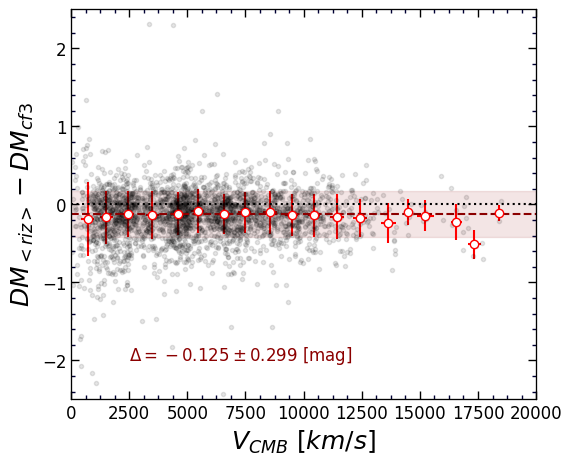

In [28]:
dff = df34[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k_new.values
Y = dff.DMriz_fid.values-dff.DM_cf3.values

ax.plot(X, Y, 'k.', alpha=0.1)

X = X[Y<1]
Y = Y[Y<1]

X = X[Y>-1.5]
Y = Y[Y>-1.5]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{<riz>}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = np.median(Y)
std = np.std(Y)
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -2, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

(-0.05343189617516231, 0.13423825221522434)


Text(2500,-0.6,'$\\Delta =-0.053\\pm0.134$ [mag]')

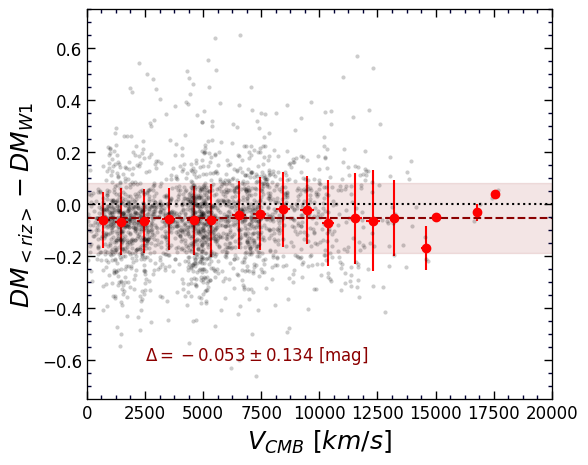

In [29]:
dff = df[(df.Qs>2)&(df.Qw>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k_new.values
Y = dff.DMriz_fid.values-dff.DM1_fid.values

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[np.abs(Y)<0.40]
Y = Y[np.abs(Y)<0.40]


for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{<riz>}-DM_{W1}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-.75,.75), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = np.median(Y)
std = np.std(Y)
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -0.6, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd5a8ff6b10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd5a780b890>)

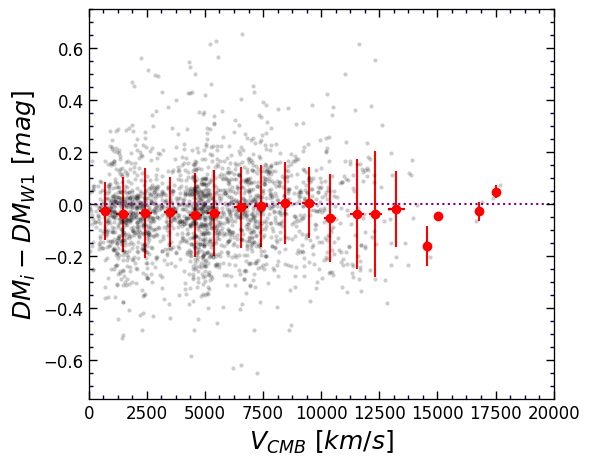

In [30]:
dff = df[(df.Qs>2)&(df.Qw>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k_new.values
Y = dff.DMi_fid.values-dff.DM1_fid.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.


ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{W1}\/\/[mag]$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.75,0.75), fontsize=12)

# ax.set_title("BTFR: W1-band")


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd5a9b34b90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd5a9ba70d0>)

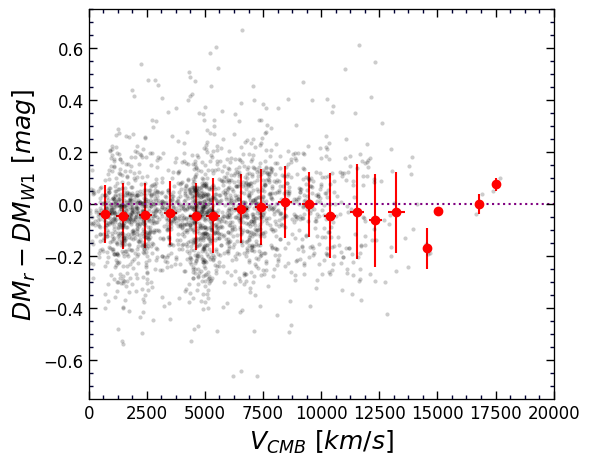

In [31]:
dff = df[(df.Qs>2)&(df.Qw>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k_new.values
Y = dff.DMr_fid.values-dff.DM1_fid.values


ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[np.abs(Y)<0.40]
Y = Y[np.abs(Y)<0.40]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{r}-DM_{W1}\/\/[mag]$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.75,0.75), fontsize=12)

# ax.set_title("BTFR: W1-band")


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd5a974ec90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd5a98aef10>)

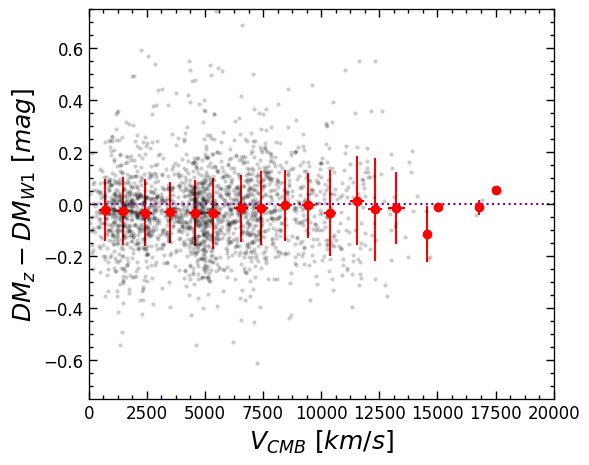

In [32]:
dff = df[(df.Qs>2)&(df.Qw>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k_new.values
Y = dff.DMz_fid.values-dff.DM1_fid.values


ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[np.abs(Y)<0.40]
Y = Y[np.abs(Y)<0.40]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{z}-DM_{W1}\/\/[mag]$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.75,0.75), fontsize=12)

# ax.set_title("BTFR: W1-band")


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd5a9496bd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd5a781fd10>)

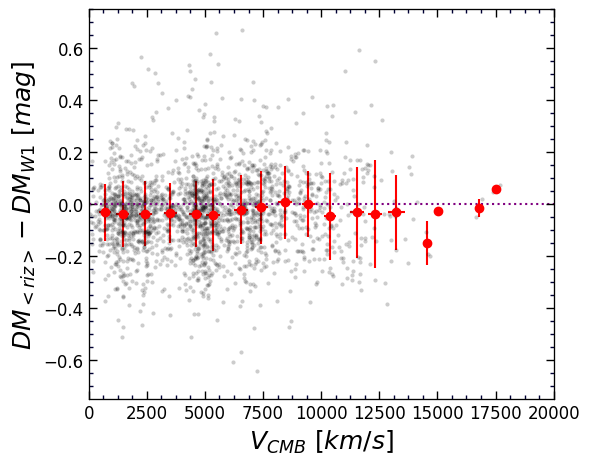

In [33]:
dff = df[(df.Qs>2)&(df.Qw>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k_new.values
Y = (dff.DMr_fid.values+dff.DMi_fid.values+dff.DMz_fid.values)/3.-dff.DM1_fid.values

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[np.abs(Y)<0.40]
Y = Y[np.abs(Y)<0.40]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{<riz>}-DM_{W1}\/\/[mag]$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.75,0.75), fontsize=12)

# ax.set_title("BTFR: W1-band")


-0.005955142418560655


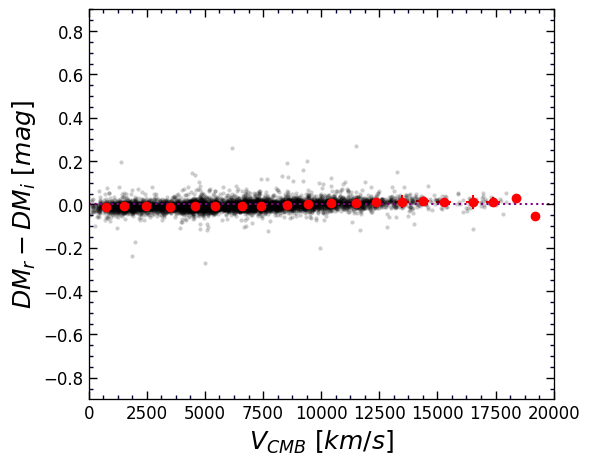

In [34]:
dff = df[(df.Qs>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

sum = 0 
# gz = dff['ggg'].values-dff['zzz'].values

# n = 4
# for i in range(n+1):
#     sum += fit_rgz[i]*gz**(n-i)

X = dff.V3k_new.values
Y = dff.DMr_fid.values-dff.DMi_fid.values - sum

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[np.abs(Y)<0.20]
Y = Y[np.abs(Y)<0.20]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{r}-DM_{i}\/\/[mag]$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.9,0.9), fontsize=12)

# ax.set_title("BTFR: W1-band")
print(np.median(Y))

0.0016064148930254873


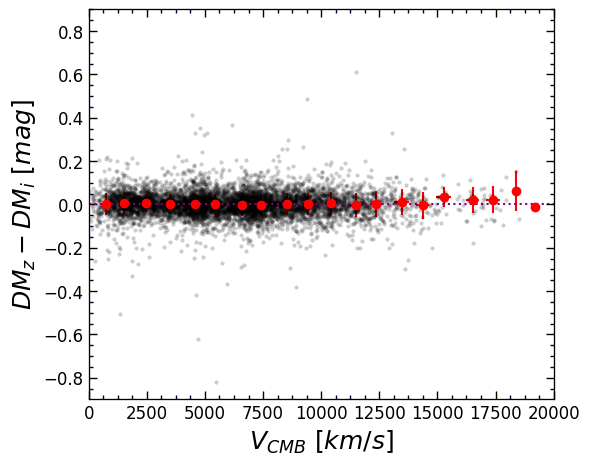

In [35]:
dff = df[(df.Qs>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k_new.values
Y = dff.DMz_fid.values-dff.DMi_fid.values

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[np.abs(Y)<0.20]
Y = Y[np.abs(Y)<0.20]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{z}-DM_{i}\/\/[mag]$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.9,0.9), fontsize=12)

# ax.set_title("BTFR: W1-band")
print(np.median(Y))

-0.0019562675768600712


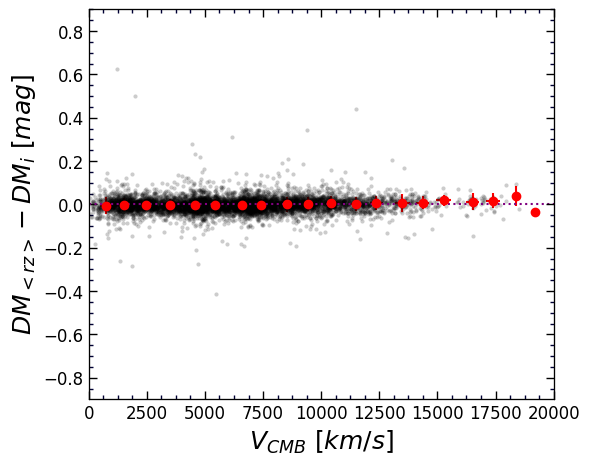

In [36]:
dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


gz = dff['ggg'].values-dff['zzz'].values
X = dff.V3k_new.values
Y = 0.5*(dff.DMz_fid.values+dff.DMr_fid.values)-dff.DMi_fid.values

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[np.abs(Y)<0.20]
Y = Y[np.abs(Y)<0.20]


for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{<rz>}-DM_{i}\/\/[mag]$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.9,0.9), fontsize=12)

print(np.median(Y))

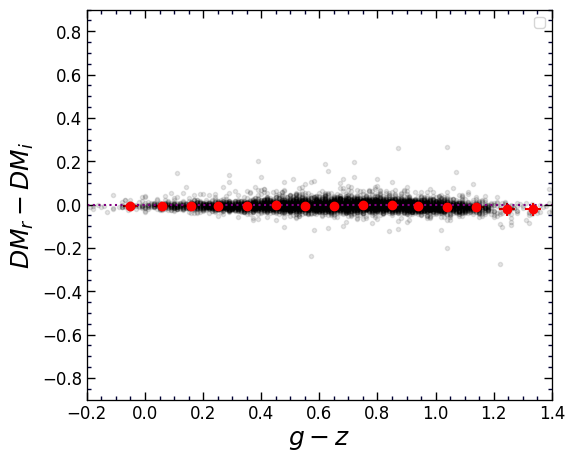

In [37]:
dff = df[(df.Qs>2)&(df.lgWmxi>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['ggg'].values-dff['zzz'].values
sum = 0 

# n = 4
# for i in range(n+1):
#     sum += fit_rgz[i]*X**(n-i)



Y = dff.DMr_fid.values-dff.DMi_fid.values - sum
ID = dff.index.values


ax.plot(X, Y, 'k.', alpha=0.1)

X = X[np.abs(Y)<0.20]
Y = Y[np.abs(Y)<0.20]

for i in np.arange(-0.1,1.4,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$g-z$', fontsize=18) 
ax.set_ylabel(r'$DM_{r}-DM_{i}$', fontsize=18)

ax.plot([-1.5, 2], [0,0], ':', color='purple')

set_axes(ax, (-.2,1.4), (-0.9,0.9), fontsize=12)


ax.legend()


# n = 4
# fit_rgz, cov_rgz = np.polyfit(X, Y, n, cov=True)
# sum = 0 
# for i in range(n+1):
#     sum += fit_rgz[i]*color**(n-i)
# ax.plot(color, sum, '--')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd5a9152e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd5a8d8cb10>)

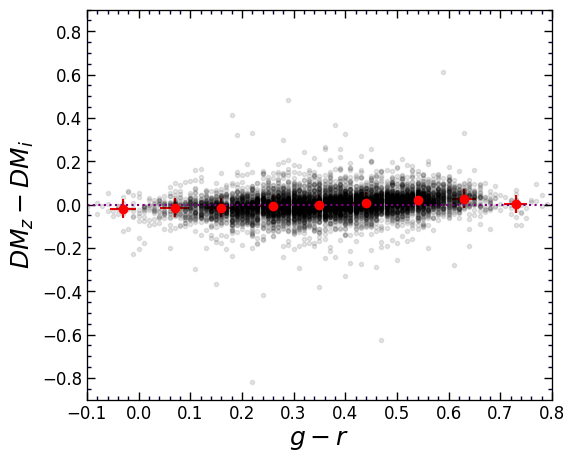

In [38]:
dff = df[(df.Qs>2)&(df.lgWmxi>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['ggg'].values-dff['rrr'].values
Y = dff.DMz_fid.values-dff.DMi_fid.values
ID = dff.index.values

ax.plot(X, Y, 'k.', alpha=0.1)

X = X[np.abs(Y)<0.20]
Y = Y[np.abs(Y)<0.20]

for i in np.arange(-0.1,1.4,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$g-r$', fontsize=18) 
ax.set_ylabel(r'$DM_{z}-DM_{i}$', fontsize=18)

ax.plot([-1.5, 2], [0,0], ':', color='purple')

set_axes(ax, (-.1,0.8), (-0.9,0.9), fontsize=12)



(<matplotlib.axes._subplots.AxesSubplot at 0x7fd5a76f1cd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd5a77129d0>)

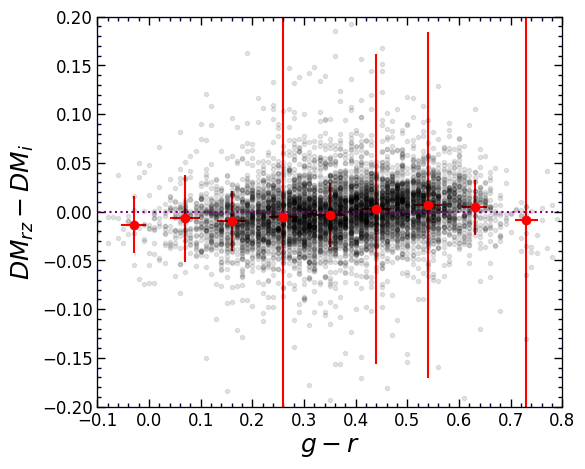

In [39]:
dff = df[(df.Qs>2)&(df.lgWmxi>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['ggg'].values-dff['rrr'].values
Y = 0.5*(dff.DMz_fid.values+dff.DMr_fid.values)-dff.DMi_fid.values
ID = dff.index.values

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(-0.1,1.4,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$g-r$', fontsize=18) 
ax.set_ylabel(r'$DM_{rz}-DM_{i}$', fontsize=18)

ax.plot([-1.5, 2], [0,0], ':', color='purple')

set_axes(ax, (-.1,0.8), (-0.2,0.2), fontsize=12)



In [28]:
PGC_outlier_1 = [    356,    1286,    1553,    2080,    2266,    2768,    3084,
          3174,    3235,    3717,    3763,    5043,    6054,    6438,
          6966,    6982,    9399,   15460,   21673,   22381,   23355,
         27640,   30358,   32707,   35942,   36349,   36466,   42938,
         43726,   45887,   50012,   51450,   53728,   66948,   67511,
         69016,   83427,   84490,   90431,   90844,   91252,  142838,
        142840,  169737, 4310833, 5057394, 5057398]

PGC_outlier_2 = [   2712,    3081,    3133,    3247,    4387,    6889,    9134,
         36778,   53291,   70708,   71795,   85607,  138562,  142824,
        169989,  170138, 1056132, 1129847, 5076801]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f768c83a580>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f768c53c7c0>)

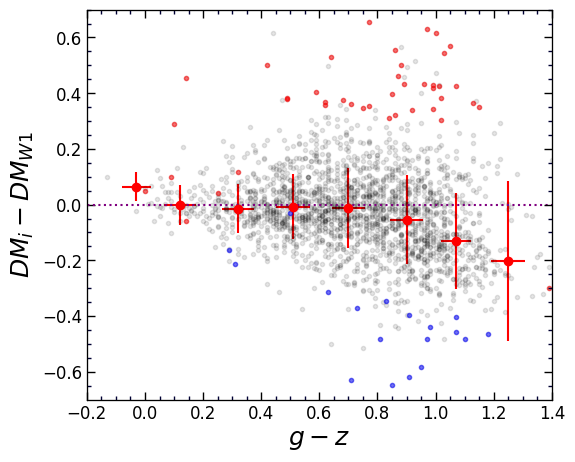

In [29]:
dff = df[(df.Qs>2)&(df.Qw>2)&(df.lgWmxi>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.ggg.values-dff.zzz.values
Y = dff.DMi_fid.values-dff.DM1_fid.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.
ID = dff.index.values

ax.plot(X, Y, 'k.', alpha=0.1)

X0 = []
Y0 = []
for i in range(len(X)):
    if ID[i] in PGC_outlier_1:
        ax.plot([X[i]], [Y[i]], 'r.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])
        
        
for i in range(len(X)):
    if ID[i] in PGC_outlier_2:
        ax.plot([X[i]], [Y[i]], 'b.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])        

X = X0
Y = Y0

for i in np.arange(-.2,1.4,0.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$g-z$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([-1.5, 2], [0,0], ':', color='purple')

set_axes(ax, (-.2,1.4), (-0.7,0.7), fontsize=12)



(<matplotlib.axes._subplots.AxesSubplot at 0x7f768c6fe610>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f768c5ae850>)

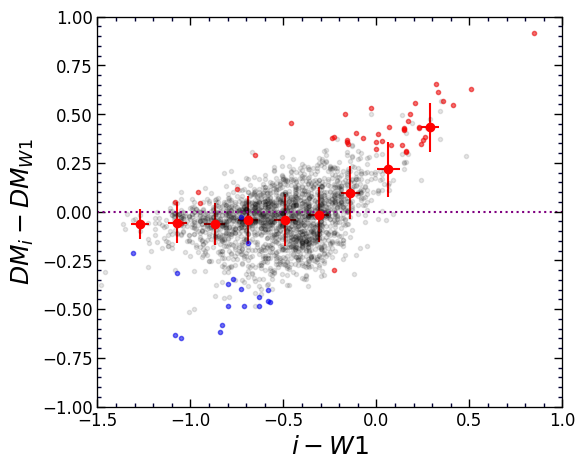

In [30]:
dff = df[(df.Qs>2)&(df.Qw>2)&(df.lgWmxi>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff["i***"].values-dff["w1***"].values
Y = dff.DMi_fid.values-dff.DM1_fid.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.
ID = dff.index.values

ax.plot(X, Y, 'k.', alpha=0.1)

X0 = []
Y0 = []
for i in range(len(X)):
    if ID[i] in PGC_outlier_1:
        ax.plot([X[i]], [Y[i]]
                , 'r.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])
        
        
for i in range(len(X)):
    if ID[i] in PGC_outlier_2:
        ax.plot([X[i]], [Y[i]], 'b.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])        

X = X0
Y = Y0
    
for i in np.arange(-1.4,0.4,0.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i-W1$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([-1.5, 1.2], [0,0], ':', color='purple')

set_axes(ax, (-1.5,1), (-1,1), fontsize=12)



(<matplotlib.axes._subplots.AxesSubplot at 0x7f769cb2d8b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f769c3ee550>)

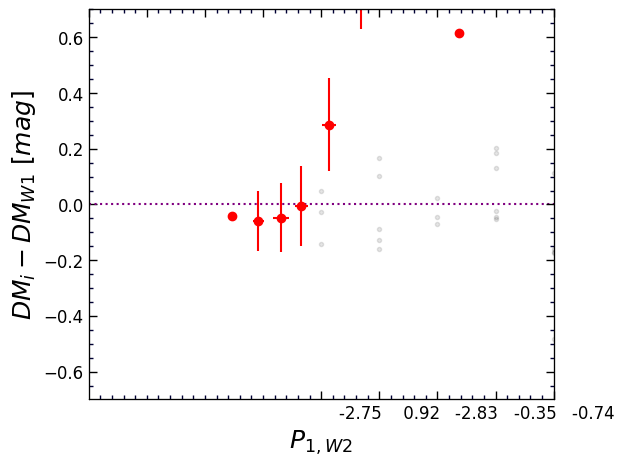

In [31]:
dff = df[(df.Qs>2)&(df.Qw>2)&(df.lgWmxi>0)]###&(df['i***']-df["w1***"]<-0.4)
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.P0.values
Y = dff.DMi_fid.values-dff.DM1_fid.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.


ID = dff.index.values

ax.plot(X, Y, 'k.', alpha=0.1)

# X0 = []
# Y0 = []
# for i in range(len(X)):
#     if ID[i] in PGC_outlier_1:
#         ax.plot([X[i]], [Y[i]]
#                 , 'r.', alpha=0.5)
#     else:
#         X0.append(X[i])
#         Y0.append(Y[i])
        
        
# for i in range(len(X)):
#     if ID[i] in PGC_outlier_2:
#         ax.plot([X[i]], [Y[i]], 'b.', alpha=0.5)
#     else:
#         X0.append(X[i])
#         Y0.append(Y[i])        

X = X0
Y = Y0

for i in np.arange(-4,4,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$P_{1,W2}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{W1}\/\/[mag]$', fontsize=18)

ax.plot([-4,4], [0,0], ':', color='purple')

set_axes(ax, (-4,4), (-0.7,0.7), fontsize=12)



(<matplotlib.axes._subplots.AxesSubplot at 0x7f769cecf2e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f769cd077c0>)

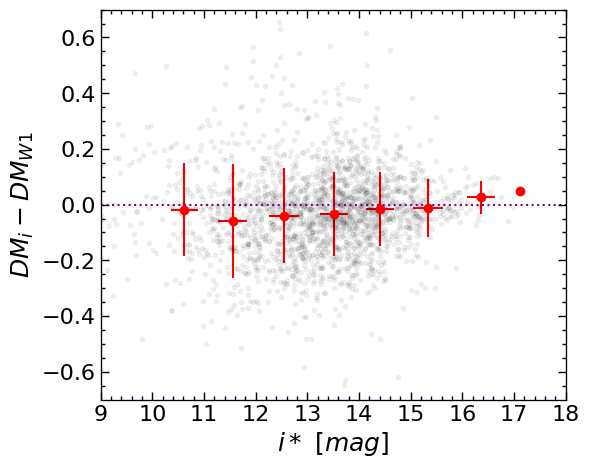

In [32]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['i***'].values
Y = dff.DMi_fid.values-dff.DM1_fid.values

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([9,18], [0,0], ':', color='purple')

set_axes(ax, (9,18), (-0.7,0.7))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f769cc5c940>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7687b1e400>)

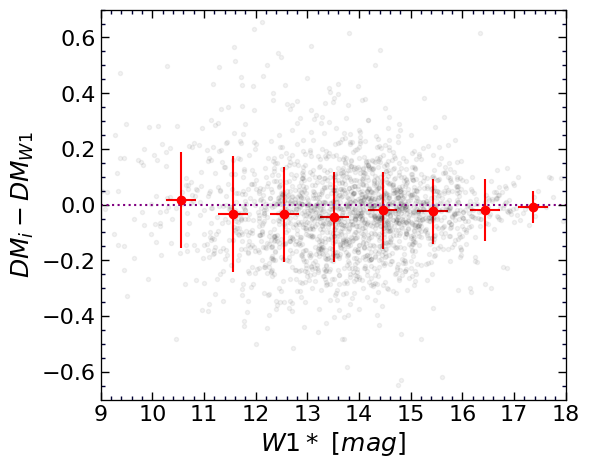

In [33]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['w1***'].values
Y = dff.DMi_fid.values-dff.DM1_fid.values

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$W1* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([9,18], [0,0], ':', color='purple')

set_axes(ax, (9,18), (-0.7,0.7))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f769c8e7df0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f769c9e7880>)

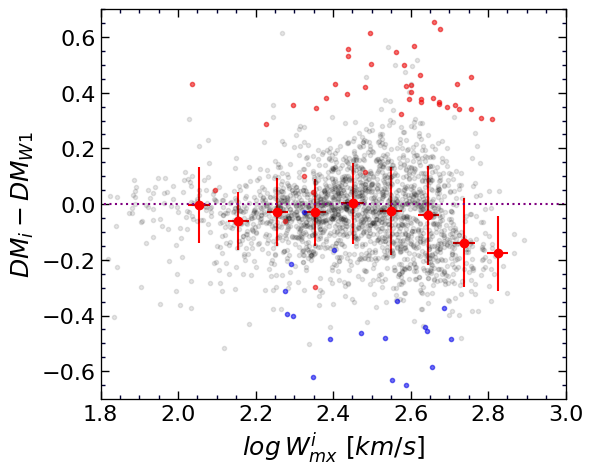

In [34]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.lgWmxi.values
Y = dff.DMi_fid.values-dff.DM1_fid.values
ID = dff.index.values

ax.plot(X, Y, 'k.', alpha=0.1)

X0 = []
Y0 = []
for i in range(len(X)):
    if ID[i] in PGC_outlier_1:
        ax.plot([X[i]], [Y[i]]
                , 'r.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])
        
        
for i in range(len(X)):
    if ID[i] in PGC_outlier_2:
        ax.plot([X[i]], [Y[i]], 'b.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])        

X = X0
Y = Y0



for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18)
ax.set_ylabel(r'$DM_{i} - DM_{W1}$', fontsize=18)

ax.plot([-10,10], [0,0], ':', color='purple')

set_axes(ax, (1.8,3), (-0.7,0.7))

# ax.set_title("BTFR: W1-band")

In [35]:
dff["delta"] = dff.DMi_fid.values-dff.DM1_fid.values

dff[(dff.Vmod_new<2500)&(dff.delta<0.1)]

<ipython-input-35-5754e7d61b77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["delta"] = dff.DMi_fid.values-dff.DM1_fid.values


,V3k_new,Vmod_new,lgWmxi,elgWi,F21,eF21,DM_75,DMr_fid,DMi_fid,DMz_fid,...,Nest,Vmodg,Nkt,N15,sglg,sgbg,RS,P0,DM_src,delta
PGC,,,,,,,,,,,,,,,,,,,,,
279,1959.0,1970.0,2.612,0.005,14.455,0.13,32.097025,32.313398,32.336544,32.384306,...,202396,1900,2,2,313.8141,17.1417,2,1.63,1,0.033508
496,548.0,549.0,1.887,0.011,4.760,0.06,29.322555,30.254707,30.274553,30.234388,...,0,519,1,0,310.3959,15.8453,0,-5.21,1,0.085183
889,501.0,502.0,1.963,0.009,13.950,0.06,29.128212,29.631457,29.625289,29.647018,...,0,502,1,0,310.4846,14.2370,2,-4.99,1,0.003223
924,1340.0,1345.0,2.187,0.011,3.665,0.08,31.268305,31.761930,31.775044,31.725662,...,0,1336,2,0,306.4152,13.1590,2,-1.88,1,-0.255926
1525,494.0,495.0,2.301,0.004,44.485,0.10,29.097720,30.716787,30.711932,30.736288,...,212367,493,1,1,310.5250,11.6066,1,-2.38104,1,-0.144889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419134,2388.0,2403.0,1.824,0.134,0.620,0.05,32.528463,31.673528,31.659108,31.598648,...,100002,1485,695,0,102.8803,-2.2970,0,-3.84,1,0.027299
4015889,2272.0,2286.0,1.948,0.014,1.985,0.08,32.420075,31.950731,31.969420,31.978304,...,100002,1485,695,0,102.8803,-2.2970,0,-4.74,1,0.093945
4017882,1979.0,1989.0,1.843,0.120,0.855,0.08,32.117868,31.720964,31.710534,31.724023,...,100002,1485,695,0,102.8803,-2.2970,0,-4.7,1,0.026170


<ipython-input-36-bc4c93c6ca4a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dff = df34[(df.Qs>2)]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f769c6ae7c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f769c7187f0>)

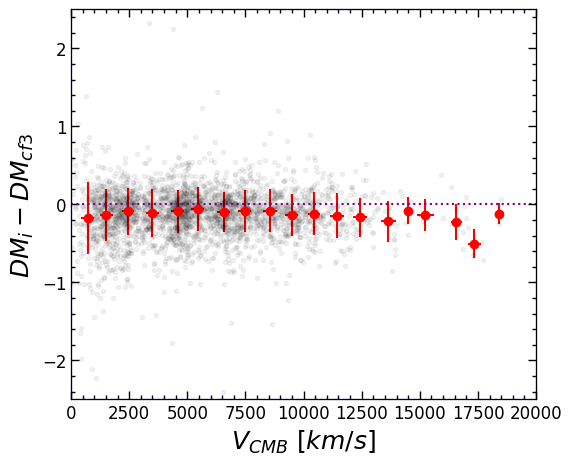

In [36]:
dff = df34[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k_new.values
Y = dff.DMi_fid.values-dff.DM_cf3.values

ax.plot(X, Y, 'k.', alpha=0.05)

X = X[Y<1]
Y = Y[Y<1]

X = X[Y>-1.5]
Y = Y[Y>-1.5]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

# ax.set_title("BTFR: W1-band")


<ipython-input-37-930a07eb3bb2>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dff = df34[(df.Qs>2)]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f769c3b3c70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f769c4ff400>)

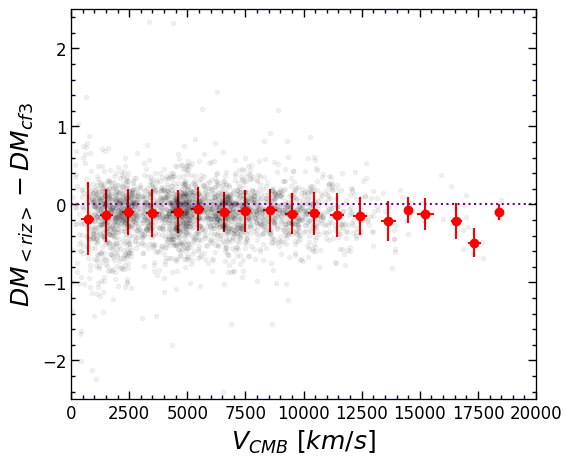

In [37]:
dff = df34[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k_new.values
Y = (dff.DMr_fid.values+dff.DMi_fid.values+dff.DMz_fid.values)/3.-dff.DM_cf3.values

ax.plot(X, Y, 'k.', alpha=0.05)

X = X[Y<1]
Y = Y[Y<1]

X = X[Y>-1.5]
Y = Y[Y>-1.5]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{<riz>}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

# ax.set_title("BTFR: W1-band")


-0.04669319494383828 0.3147123988923989


<ipython-input-38-cf3a5541b254>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dff = df34[(df.Qw>2)]


Text(2500, -2, '$\\Delta =-0.047\\pm0.315$ [mag]')

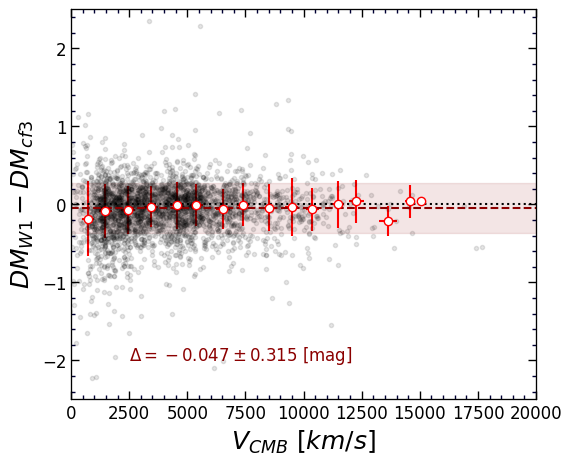

In [38]:
dff = df34[(df.Qw>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k_new.values
Y = dff.DM1_fid.values-dff.DM_cf3.values

ax.plot(X, Y, 'k.', alpha=0.1)

X = X[Y<1]
Y = Y[Y<1]

X = X[Y>-1.5]
Y = Y[Y>-1.5]

for i in np.arange(0,16000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{W1}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = np.median(Y)
std = np.std(Y)
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -2, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

In [28]:
# from astropy.table import Table, Column

# df_ = df.reset_index()

# df_.to_csv('BTFR_CF4_Dist_bar.csv', sep='|', index=False)


# table   = np.genfromtxt('BTFR_CF4_Dist_bar.csv' , delimiter='|', 
#                         filling_values=-100000, names=True, dtype=None, encoding=None)

# colnames = table.dtype.names

# ## table is a structured array
# myTable = {}
# for name in table.dtype.names:
#     myTable[name] = table[name]
# table = myTable
# ## table is now a dictionary

# myTable = Table()

# for key in colnames:
#     if key in ["PGC"]:
#         myTable.add_column(Column(data=table[key], name=key))
#     elif key in ["F21", "eF21", "lgWmxi", "elgWi"]:
#         myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))    
#     elif key in ["Vls", 'V3k', 'Vmod', "Qs", "Qw"]:
#         myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int)))
#     elif key in ["P0", "ggg", "rrr", "iii", "zzz"]:
#         pass
#     else:
#         myTable.add_column(Column(data=table[key], name=key, format='%0.2f'))

# ## to be used on EDD
# myTable.write('BTFR_CF4_Dist_bar', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)
# ## cf4btfdistances

In [29]:
# fig = py.figure(figsize=(5,4), dpi=100)    
# fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
# ax = fig.add_subplot(111)

# bins = np.arange(1.4,3,0.1)

# ax.hist(df_[df_.Qs>0].lgWmxi, bins=bins, alpha=0.5, density=True, label='optical (Qs>0)')
# ax.hist(df_[df_.Qw>0].lgWmxi, bins=bins, alpha=1, density=True, histtype='step', color='red', label='Infrared (Qw>0)')

# ax.legend(loc=2)

# ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=14)
# ax.set_ylabel('Normalized Count', fontsize=14)

# set_axes(ax, (1.3,3), (0,2.2), fontsize=12)


In [30]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [214]:
def myHubble(D, H0):
    return H0    


def plotHubble(ax, X, Y, Ye, band=""):
       
    ax.plot(X, 10**Y, 'k.', alpha=0.1, mec='white', ms=5)
    
#     m = np.median(Y[X>4000])
#     e1 = np.std(Y[X>4000])/np.sqrt(len(Y[X>4000])) 
#     e2 = m/np.sqrt(len(Y[X>4000])) 
#     e = np.sqrt(e1**2)
#     H0e_fit = 10**m*e*np.log(10)    
    
    for i in np.arange(0,18000, 1000):
        xp = []
        yp = []
        ype  = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+1000 and Y[ii]>-10000: #and Ye[ii]>0:
                xp.append(xi)
                yp.append(Y[ii])
                ype.append(Ye[ii])
        if len(xp)>2:
            yp = np.asarray(yp)
            ype = np.asarray(ype)
            
            fit, cov = curve_fit(myHubble, xp, yp, sigma=ype)
            yy = fit[0]
            e = np.sqrt(cov[0])
            H0e_fit = (10**yy)*np.log(10.)*np.sqrt(cov[0])
            H0 = 10**yy  
    
            if np.median(xp)>4000:
                ax.errorbar(i+500, 10**yy, yerr=H0e_fit, xerr=np.std(xp), fmt='o', 
                        color='r', ms=5, capsize=2)     
            else:
                ax.errorbar(i+500, 10**yy, yerr=H0e_fit, xerr=np.std(xp), fmt='o', 
                        color='r', ms=5, mfc='white', capsize=2)  
            

    
    fit, cov = curve_fit(myHubble, X[X>4000], Y[X>4000], sigma=Ye[X>4000])
    yy = fit[0]
    sigma = np.std(Y[X>4000]-yy)
    
    
    ind = ((X>4000)&(np.abs(Y-yy)<3.5*sigma))
    fit, cov = curve_fit(myHubble, X[ind], Y[ind], sigma=Ye[ind])
    yy = fit[0]
    H0e_fit = (10**yy)*np.log(10.)*np.sqrt(cov[0])
    H0 = 10**yy  

    ax.plot([4000,20000], [H0, H0], '--', color='blue')

    x_ax, y_ax = set_axes(ax, (0,20000), (35,150), fontsize=14) 

    ax.set_yscale('log')

    from matplotlib.ticker import MultipleLocator

    from matplotlib.ticker import NullFormatter
    
    ax.set_yticks(np.arange(30,150, step=30))
    ax.yaxis.set_major_formatter(NullFormatter())  
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    plt.yticks([40, 70, 100, 130], ('40', '70', '100','130'))


    y_ax.set_yticks(np.arange(30,150, step=30))
    y_ax.set_yscale('log')
    y_ax.yaxis.set_major_formatter(NullFormatter())  
    y_ax.yaxis.set_minor_formatter(NullFormatter())
    y_ax.yaxis.set_major_locator(MultipleLocator(30))
    y_ax.yaxis.set_minor_locator(MultipleLocator(10))


    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.80*Xlm[0]+0.20*Xlm[1]
    y0 = 0.95*Ylm[0]+0.05*Ylm[1] 
    unit= '   km/s/Mpc'
    ax.text(x0,y0, r"$ \langle H_0 \rangle_{"+band+"}= $"+"%.1f" % H0+'$\pm$'+"%.1f" % H0e_fit+unit, fontsize=14, 
            color='blue', backgroundcolor='white')

    ax.xaxis.set_major_formatter(OOMFormatter(3, "%d"))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(3,3))



In [215]:
df_paper.columns

Index([u'PGC', u'DM_av', u'DMriz_fid', u'DMriz_err', u'DM1_fid', u'DM1_err',
       u'PGC1', u'Nest', u'logMs_riz', u'logMs_W1', u'logMgas', u'logMb',
       u'Vh', u'Vls', u'V3k', u'Vmod', u'f_cosmology', u'logWimx',
       u'logWimx_e', u'F21', u'eF21', u'inc', u'inc_e', u'ggg', u'rrr', u'iii',
       u'zzz', u'w1', u'Qs', u'Qw', u'RA', u'DEC', u'gl', u'gb', u'sgl',
       u'sgb', u'Nkt', u'N15', u'sglg', u'sgbg', u'Vmodg'],
      dtype='object')

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log10
/media/Data/Hom

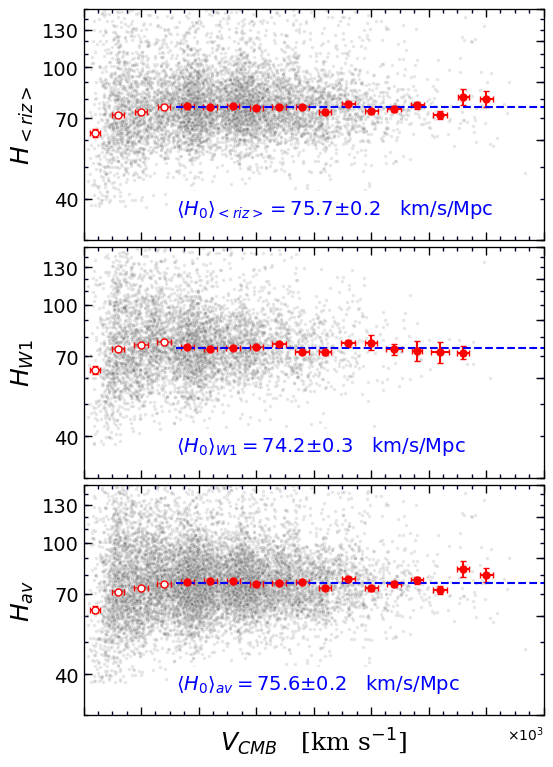

In [216]:
fig = py.figure(figsize=(5, 11.8), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(4,1) ; p=0

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

####################################################
####################################################
ax = plt.subplot(gs[p]) ; p+=1

dff = df_paper[(df_paper.Qs>2)&(df_paper.logWimx>0)]
X = dff.V3k.values
Y  = np.log10(dff.Vmod.values)-(dff.DMriz_fid.values-25)/5.
Ye = dff.DMriz_err.values/5.

Y0 = dff.Vmod.values
DM_75 = 5*np.log10(Y0/75.)+25.
Y0 = DM_75-dff.DMriz_fid.values

ind, = np.where(np.abs(Y0)<1.5)

plotHubble(ax, X[ind], Y[ind], Ye[ind], band="<riz>")
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel(r'$H_{<riz>}$', fontsize=18, fontdict=font) 
####################################################
ax = plt.subplot(gs[p]) ; p+=1

dff = df_paper[(df_paper.Qw>2)&(df_paper.logWimx>0)]
X = dff.V3k.values
Y  = np.log10(dff.Vmod.values)-(dff.DM1_fid.values-25)/5.
Ye = dff.DM1_err.values/5.

Y0 = dff.Vmod.values
DM_75 = 5*np.log10(Y0/75.)+25.
Y0 = DM_75-dff.DM1_fid.values

ind, = np.where(np.abs(Y0)<1.5)
plotHubble(ax, X[ind], Y[ind], Ye[ind], band="W1")
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel(r'$H_{W1}$', fontsize=18, fontdict=font) 

####################################################
ax = plt.subplot(gs[p]) ; p+=1

dff = df_paper[((df_paper.Qw>2)|(df_paper.Qs>2))&(df_paper.logWimx>0)]
X = dff.V3k.values
Y  = np.log10(dff.Vmod.values)-(dff.DM_av.values-25)/5.
Ye = dff[["DMriz_err", "DM1_fid"]].mean(axis=1).values/5.

Y0 = dff.Vmod.values
DM_75 = 5*np.log10(Y0/75.)+25.
Y0 = DM_75-dff.DM_av.values

ind, = np.where(np.abs(Y0)<1.5)
plotHubble(ax, X[ind], Y[ind], Ye[ind], band="av")
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel(r'$H_{av}$', fontsize=18, fontdict=font) 



ax.set_xlabel(r'$V_{CMB} $'+'   [km s'+r'$^{-1}$'+']', fontsize=18, fontdict=font) 


plt.subplots_adjust(hspace=0.03, wspace=0.2)

In [217]:
dff.columns

Index([u'PGC', u'DM_av', u'DMriz_fid', u'DMriz_err', u'DM1_fid', u'DM1_err',
       u'PGC1', u'Nest', u'logMs_riz', u'logMs_W1', u'logMgas', u'logMb',
       u'Vh', u'Vls', u'V3k', u'Vmod', u'f_cosmology', u'logWimx',
       u'logWimx_e', u'F21', u'eF21', u'inc', u'inc_e', u'ggg', u'rrr', u'iii',
       u'zzz', u'w1', u'Qs', u'Qw', u'RA', u'DEC', u'gl', u'gb', u'sgl',
       u'sgb', u'Nkt', u'N15', u'sglg', u'sgbg', u'Vmodg'],
      dtype='object')